In [18]:
import glob
from os.path import join, expanduser
import xarray as xr
import dask
import numpy as np
import pandas as pd
from pathlib import Path
import intake
import cftime
import datetime as dt
from dask.distributed import Client
from dask_jobqueue import PBSCluster


## Find your files:

In [50]:
sim_path = "/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/" 
variable = "PRECT"

# example for one ensemble member: 
ensemble_member = "011"
sim_files = sorted(glob.glob(join(sim_path,variable,"b.e21.BHISTsmbb.f09_g17.LE2-1301.*.nc")))

# How many files?
print (len(sim_files))
print("\n".join(sim_files))


170
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18500101-18591231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18600101-18691231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18700101-18791231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18800101-18891231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18900101-18991231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.19000101-19091231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.19100101-19191231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/P

## Using Dask: 
Let's scale everything up using Dask.

In [20]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '30:00',
    interface = 'ext'
)

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41291 instead
  warnings.warn(


In [21]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/41291/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/41291/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.106:37907,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/41291/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [22]:
num_workers = 32 
cluster.scale(num_workers)

client.wait_for_workers(num_workers)

In [23]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
2081278.casper* negins   htc      STDIN        8965   1   1    4gb 24:00 R 00:29
2081294.casper* negins   jhublog* cr-login-*  32756   1   1    4gb 720:0 R 00:26
2081637.casper* negins   htc      dask-wk23*  59393   1   1    4gb 00:30 R 00:03
2081638.casper* negins   htc      dask-wk23*  59404   1   1    4gb 00:30 R 00:03
2081639.casper* negins   htc      dask-wk23*  13797   1   1    4gb 00:30 R 00:03
2081640.casper* negins   htc      dask-wk23*  13808   1   1    4gb 00:30 R 00:03
2081641.casper* negins   htc      dask-wk23*  59832   1   1    4gb 00:30 R 00:03
2081642.casper* negins   htc      dask-wk23*  59843   1   1    4gb 00:30 R 00:03
2081643.casper* negins   htc      dask-wk23*  64715   1   1    4gb 00:30 R 00:03
2081644.casper* negins   htc  

## Read in all Files: 

In [58]:
%%time
ds = xr.open_mfdataset(
    sorted(sim_files),
    # concatenate files in the order provided
    combine="by_coords",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)



CPU times: user 1.29 s, sys: 109 ms, total: 1.4 s
Wall time: 5.1 s


In [ ]:
%%time
# decode cftime ## not required with newer Xr version
ds = xr.decode_cf(ds)
ds

In [56]:
precip = ds.PRECT
precip

<xarray.DataArray 'PRECT' (time: 60226, lat: 192, lon: 288)> Size: 13GB
dask.array<concatenate, shape=(60226, 192, 288), dtype=float32, chunksize=(606, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 482kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

## Calculate Maximum Precip Per Year Per Ensemble: 

Note how the ouput dimensions (year: 166lat: 192lon: 288)

In [43]:
## calculate annual maximum: 

max_precip = precip.groupby(precip.time.dt.year, ).max()
max_precip

<xarray.DataArray 'PRECT' (year: 166, lat: 192, lon: 288)> Size: 37MB
dask.array<transpose, shape=(166, 192, 288), dtype=float32, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2012 2013 2014 2015
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

## Now you want to to save maximum Precip per year for each ensemble member: 

In [46]:
%%time
## check out the dashboard for compute heavy: 
save_precip = max_precip.compute()

CPU times: user 1.38 s, sys: 261 ms, total: 1.64 s
Wall time: 8.54 s


In [47]:
output_file = "save_output_"+ensemble_member+".nc"
# Now, save the annual maxima time series for each ensemble member
save_precip.to_netcdf("b.e21.BHISTsmbb.f09_g17.LE2-1301.001.cam.h1.Rx1day.18500101-20141231.nc")

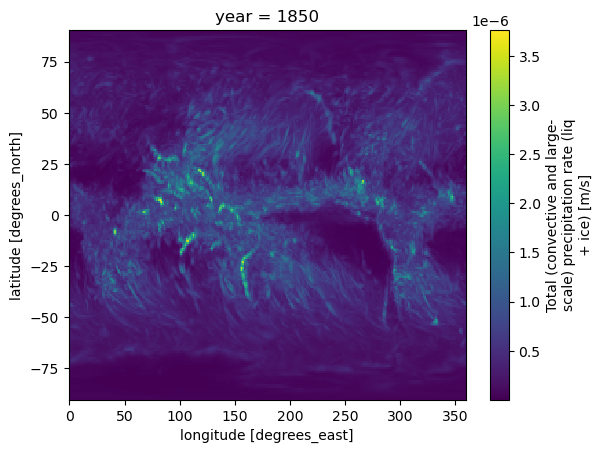

In [48]:
save_precip.sel(year=1850).plot()